<a href="https://colab.research.google.com/github/ANadalCardenas/attention/blob/main/Copy_of_lab_gan_todo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN + conditional DCGAN


Notebook created by [Daniel Fojo](https://www.linkedin.com/in/daniel-fojo/) for the [Postgraduate course in artificial intelligence with deep learning](https://www.talent.upc.edu/ing/estudis/formacio/curs/310400/postgrau-artificial-intelligence-deep-learning/) in [UPC School](https://www.talent.upc.edu/ing/) (2020). Updated by [Mariona Carós](https://es.linkedin.com/in/mariona-c-a7bb91105) in 2022.
Minor contributions by [Gerard I. Gállego](https://www.linkedin.com/in/gerard-gallego/) and [Juan José Nieto](https://www.linkedin.com/in/juan-jose-nieto-salas/) during 2022.

In this notebook you will learn about Generative Adversarial Networks by implementing a DCGAN to generate images from noise.

**Important:** Set the Colab environment to run on GPU

In [1]:
import torch
from torch import nn, optim
from torchvision import transforms, datasets, utils
from PIL import Image
import numpy as np
import math
from IPython.display import display
from tqdm import tqdm
from itertools import cycle
from typing import Tuple

In [2]:
seed = 123
np.random.seed(seed)
_ = torch.manual_seed(seed)
_ = torch.cuda.manual_seed(seed)

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Defining the Hyper-parameters**

We now define the hyperparameters that are going to be used throughout the notebook to define the network.


In [4]:
hparams = {
    'batch_size':128,
    'num_epochs':20,
    'learning_rate':0.0002,
    'betas':(0.5, 0.999),
    'noise_size':100,
    'num_val_samples':25,
    'num_classes':10,
    'num_input_channels':1,
}

### Dataset and Data Loader
Download and prepare dataset and datalaoder


In [5]:
train_transforms = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=train_transforms,
)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=hparams['batch_size'],
    shuffle=True,
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 503kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.68MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.9MB/s]


# DCGAN

First, lets define our simple generator network.

### Exercise 1: Generator

The generator takes random noise as input and gives an image as output. Your exercise is to create the generator model.

It should follow these guidelines:
* The input will be a vector with random noise of size `noise_size`
* You should first apply a fully connected with output size 512\*4\*4 (channels\*height\*width)
* Then you should apply 3 blocks of:
    * TransposedConvolution with kernel size 4, stride 2 and padding 1. For the first 2 blocks, the output channels should be 256 and 128. For the third block, the output channels should be the correct one to generate images of the dataset.
    * BatchNorm2d except for the last block.
    * ReLU activation for the first 2 blocks and Tanh for the third block.

**Hint**: Remember to use reshape where necessary

In [6]:
class Generator(torch.nn.Module):

    def __init__(self, noise_size: int, num_input_channels: int):
        super().__init__()

        # TODO: Create the Fully connected layer using nn.Linear
        self.fc = nn.Linear(noise_size, 512 * 4 * 4)

        # TODO: Create the first block
        self.convt1 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False), # (B, 256, 8, 8)
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        # TODO: Create the second block
        self.convt2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False), # (B, 128, 16, 16)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # TODO: Create the third block using nn.Sequential with ConvTranspose2d, and activation
        self.convt3 = nn.Sequential(
            nn.ConvTranspose2d(128, num_input_channels, kernel_size=4, stride=2, padding=1, bias=False), # (B, num_input_channels, 32, 32)
            nn.Tanh(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # TODO: Define the forward of the generator, x are random noise vectors (B, noise_size)
        x = self.fc(x)
        x = x.reshape(x.shape[0], 512, 4, 4) # (B, channels, height, width)
        x = self.convt1(x)
        x = self.convt2(x)
        x = self.convt3(x)

        return x

Similarly, let's define a simple discriminator

### Exercise 2: Discriminator

The discriminator takes an image as input and classifies it between Real or Fake (1 or 0). Your exercise is to create the discriminator model.

It should follow these guidelines:
* The input will be an image of size `[num_input_channels, 32, 32]`
* You should apply 3 blocks of:
    * Convolution with kernel size 4, stride 2 and padding 1. The output channels should be 128, 256 and 512.
    * BatchNorm2d except for the first block.
    * LeakyReLU activation (alpha=0.2)
* Then you should apply a fully connected with input size 512\*4\*4 (channels\*height\*width) and the correct output size and activation for binary classification


**Hint**: Remember to use reshape/flatten where necessary

In [7]:
class Discriminator(torch.nn.Module):

    def __init__(self, num_input_channels: int):
        super().__init__()

        # TODO: Create the first block
        self.conv1 = nn.Sequential(
            nn.Conv2d(num_input_channels, 128, kernel_size=4, stride=2, padding=1, bias=False), # (B, 128, 16, 16)
            nn.LeakyReLU(0.2),
        )

        # TODO: Create the second block
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False), # (B, 256, 8, 8)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )

        # TODO: Create the third block
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False), # (B, 512, 4, 4)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )

        # TODO: Create the fully connected block using nn.Sequential with Linear and activation
        self.fc = nn.Sequential(
            nn.Linear(512 * 4 * 4, 1),
            nn.Sigmoid(), # Binary classification (real vs false)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # TODO: Define the forward of the discriminator, x are images (B, num_input_channels, 32, 32)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.reshape(x.shape[0], -1) # (B, channels * height * width)
        x = self.fc(x)

        return x

In [8]:
generator = Generator(hparams['noise_size'], hparams['num_input_channels']).to(device)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=hparams['learning_rate'], betas=hparams['betas'])

discriminator = Discriminator(hparams['num_input_channels']).to(device)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=hparams['learning_rate'], betas=hparams['betas'])

criterion = nn.BCELoss()

def init_weights(m):
    if type(m) in {nn.Conv2d, nn.ConvTranspose2d, nn.Linear}:
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias != None:
            torch.nn.init.constant_(m.bias, 0.0)
    if type(m) == nn.BatchNorm2d:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)

generator.apply(init_weights)
discriminator.apply(init_weights);


## Train function

### Exercise 3: Train

Complete the code. Take into account which labels should be used at each step of the training.

In [9]:
def train_batch(
        real_samples: torch.Tensor,
        generator: torch.nn.Module,
        discriminator: torch.nn.Module,
        optimizer_g: torch.optim,
        optimizer_d: torch.optim,
        ) -> Tuple[float, float]:

    generator.train()
    discriminator.train()

    bsz = real_samples.shape[0]

    # TODO: Define the labels for the real (ones) and fake (zeros) images of size (bsz, 1)
    label_real = torch.ones(bsz, 1)
    label_fake = torch.zeros(bsz, 1)

    label_real = label_real.to(device)
    label_fake = label_fake.to(device)

    ####################
    # OPTIMIZE GENERATOR
    ####################

    # Reset gradients
    optimizer_g.zero_grad()

    # Generate fake samples
    z = torch.randn(bsz, hparams['noise_size'], device=device)
    fake_samples = generator(z)

    # Evaluate the generated samples with the discriminator
    predictions_g_fake = discriminator(fake_samples)
    # Calculate error with respect to what the generator wants
    loss_g = criterion(predictions_g_fake, label_real)

    # Backpropagate
    loss_g.backward()

    # Update weights (do a step in the optimizer)
    optimizer_g.step()

    ########################
    # OPTIMIZE DISCRIMINATOR
    ########################

    fake_samples = fake_samples.detach() # Let's detach them to freeze the generator

    # Reset gradients
    optimizer_d.zero_grad()

    # Calculate discriminator prediction for real samples
    predictions_d_real = discriminator(real_samples)

    # Calculate error with respect to what the discriminator wants
    loss_d_real = criterion(predictions_d_real, label_real)

    # Calculate discriminator loss for fake samples
    predictions_d_fake = discriminator(fake_samples)

    # Calculate error with respect to what the discriminator wants
    loss_d_fake = criterion(predictions_d_fake, label_fake)

    # Total discriminator loss
    loss_d = (loss_d_real + loss_d_fake) / 2
    loss_d.backward()

    # Update weights (do a step in the optimizer)
    optimizer_d.step()

    return loss_g.item(), loss_d.item()


## Evaluation function

In [10]:
@torch.no_grad()
def evaluate(generator: torch.nn.Module, z_val: torch.Tensor) -> Image.Image:

    generator.eval()
    fake_samples = generator(z_val).cpu()
    # select a sample or create grid if img is a batch
    nrows = int(math.sqrt(fake_samples.shape[0]))
    img = utils.make_grid(fake_samples, nrow=nrows)

    # unnormalize
    img = (img*0.5 + 0.5)*255

    # to numpy
    image_numpy = img.numpy().astype(np.uint8)
    image_numpy = np.transpose(image_numpy, (1, 2, 0))

    return Image.fromarray(image_numpy)


## Train loop


Epoch: 1/20, batch: 200/469, G_loss: 3.8446974754333496, D_loss: 0.16074436902999878


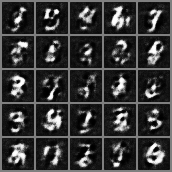


Epoch: 1/20, batch: 400/469, G_loss: 2.827052354812622, D_loss: 0.31797897815704346


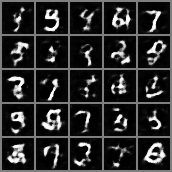


Epoch: 1/20, batch: 469/469, G_loss: 3.3498806953430176, D_loss: 0.09614024311304092


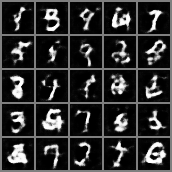


Epoch: 2/20, batch: 200/469, G_loss: 2.7339835166931152, D_loss: 0.10632871091365814


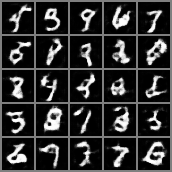


Epoch: 2/20, batch: 400/469, G_loss: 3.4154558181762695, D_loss: 0.41075700521469116


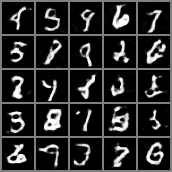


Epoch: 2/20, batch: 469/469, G_loss: 2.6760852336883545, D_loss: 0.29746973514556885


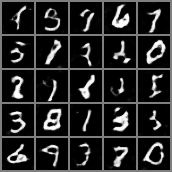


Epoch: 3/20, batch: 200/469, G_loss: 1.316562294960022, D_loss: 0.30195286870002747


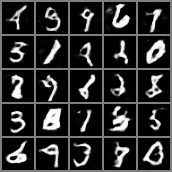


Epoch: 3/20, batch: 400/469, G_loss: 2.1368582248687744, D_loss: 0.10635092854499817


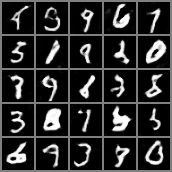


Epoch: 3/20, batch: 469/469, G_loss: 2.5267043113708496, D_loss: 0.3578346371650696


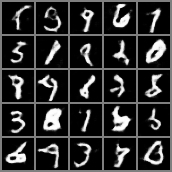


Epoch: 4/20, batch: 200/469, G_loss: 1.922897458076477, D_loss: 0.18429140746593475


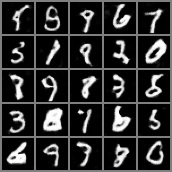


Epoch: 4/20, batch: 400/469, G_loss: 2.7726855278015137, D_loss: 0.09515911340713501


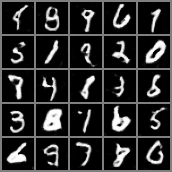


Epoch: 4/20, batch: 469/469, G_loss: 3.260657787322998, D_loss: 0.09797017276287079


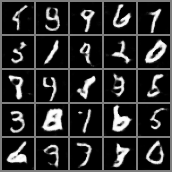


Epoch: 5/20, batch: 200/469, G_loss: 2.588313102722168, D_loss: 0.0738593190908432


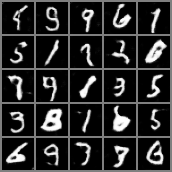


Epoch: 5/20, batch: 400/469, G_loss: 2.9360692501068115, D_loss: 0.07920073717832565


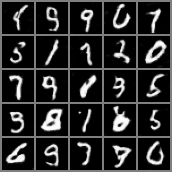


Epoch: 5/20, batch: 469/469, G_loss: 4.190702438354492, D_loss: 0.0358223021030426


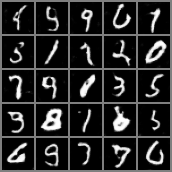


Epoch: 6/20, batch: 200/469, G_loss: 3.672597646713257, D_loss: 0.048574306070804596


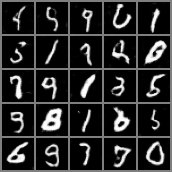


Epoch: 6/20, batch: 400/469, G_loss: 4.092219352722168, D_loss: 0.0351853147149086


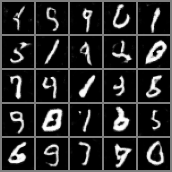


Epoch: 6/20, batch: 469/469, G_loss: 4.467446804046631, D_loss: 0.027334032580256462


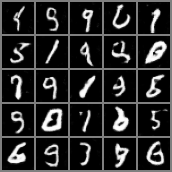


Epoch: 7/20, batch: 200/469, G_loss: 3.3447623252868652, D_loss: 0.03830055892467499


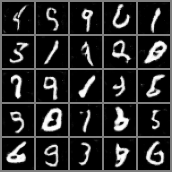


Epoch: 7/20, batch: 400/469, G_loss: 2.4773664474487305, D_loss: 0.13649506866931915


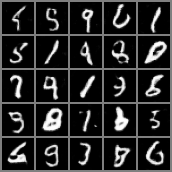


Epoch: 7/20, batch: 469/469, G_loss: 2.634373664855957, D_loss: 0.07206903398036957


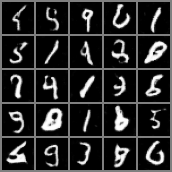


Epoch: 8/20, batch: 200/469, G_loss: 5.50190544128418, D_loss: 0.012062860652804375


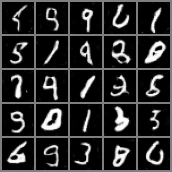


Epoch: 8/20, batch: 400/469, G_loss: 3.75253963470459, D_loss: 0.04020538553595543


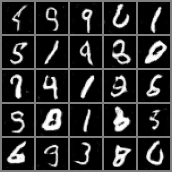


Epoch: 8/20, batch: 469/469, G_loss: 5.339654445648193, D_loss: 0.019562717527151108


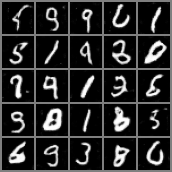


Epoch: 9/20, batch: 200/469, G_loss: 5.702600955963135, D_loss: 0.008510667830705643


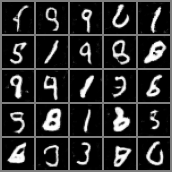


Epoch: 9/20, batch: 400/469, G_loss: 6.060127258300781, D_loss: 0.009860865771770477


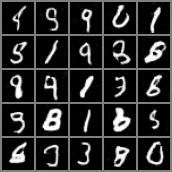


Epoch: 9/20, batch: 469/469, G_loss: 4.8890204429626465, D_loss: 0.008932151831686497


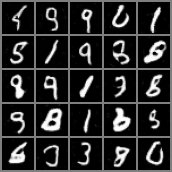


Epoch: 10/20, batch: 200/469, G_loss: 3.3509743213653564, D_loss: 0.2846090793609619


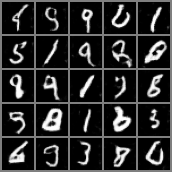


Epoch: 10/20, batch: 400/469, G_loss: 3.388948678970337, D_loss: 0.4359724819660187


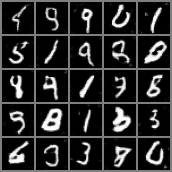


Epoch: 10/20, batch: 469/469, G_loss: 2.4111602306365967, D_loss: 0.10308050364255905


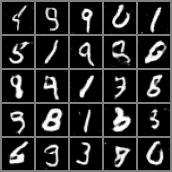


Epoch: 11/20, batch: 200/469, G_loss: 5.602076530456543, D_loss: 0.007589254062622786


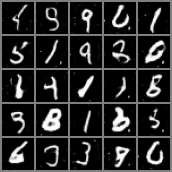


Epoch: 11/20, batch: 400/469, G_loss: 5.941402435302734, D_loss: 0.008425064384937286


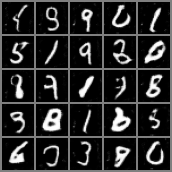


Epoch: 11/20, batch: 469/469, G_loss: 5.2935404777526855, D_loss: 0.007452360354363918


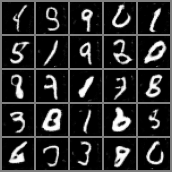


Epoch: 12/20, batch: 200/469, G_loss: 6.027115821838379, D_loss: 0.003919626586139202


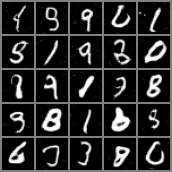


Epoch: 12/20, batch: 400/469, G_loss: 6.924942493438721, D_loss: 0.005243264138698578


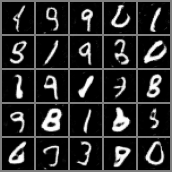


Epoch: 12/20, batch: 469/469, G_loss: 6.4846014976501465, D_loss: 0.0019874069839715958


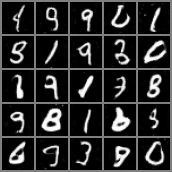


Epoch: 13/20, batch: 200/469, G_loss: 5.84702205657959, D_loss: 0.004518437199294567


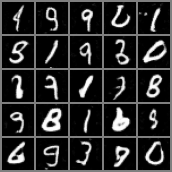


Epoch: 13/20, batch: 400/469, G_loss: 2.5467734336853027, D_loss: 0.213748037815094


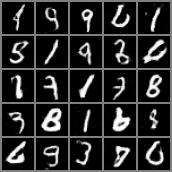


Epoch: 13/20, batch: 469/469, G_loss: 2.85186767578125, D_loss: 0.36138254404067993


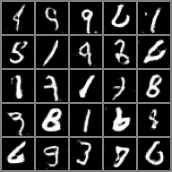


Epoch: 14/20, batch: 200/469, G_loss: 3.301413059234619, D_loss: 0.31105881929397583


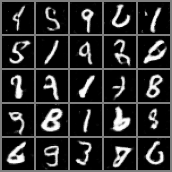


Epoch: 14/20, batch: 400/469, G_loss: 5.854373931884766, D_loss: 0.013226153329014778


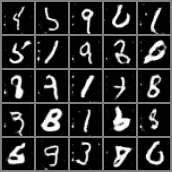


Epoch: 14/20, batch: 469/469, G_loss: 5.706787109375, D_loss: 0.009785711765289307


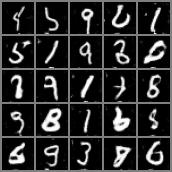


Epoch: 15/20, batch: 200/469, G_loss: 5.907707214355469, D_loss: 0.004932662937790155


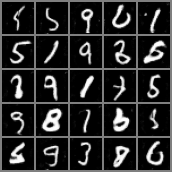


Epoch: 15/20, batch: 400/469, G_loss: 6.359768390655518, D_loss: 0.003796455916017294


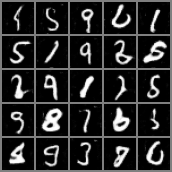


Epoch: 15/20, batch: 469/469, G_loss: 5.876500606536865, D_loss: 0.006689750123769045


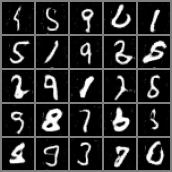


Epoch: 16/20, batch: 200/469, G_loss: 6.280033111572266, D_loss: 0.004850507713854313


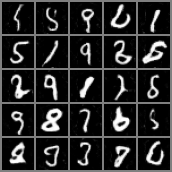


Epoch: 16/20, batch: 400/469, G_loss: 6.9658203125, D_loss: 0.0026235682889819145


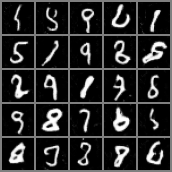


Epoch: 16/20, batch: 469/469, G_loss: 1.1569974422454834, D_loss: 0.316847562789917


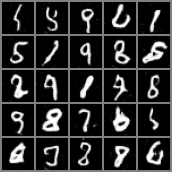


Epoch: 17/20, batch: 200/469, G_loss: 1.5931663513183594, D_loss: 0.3145157992839813


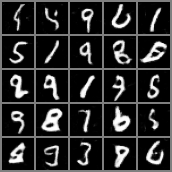


Epoch: 17/20, batch: 400/469, G_loss: 5.8849005699157715, D_loss: 0.013210689648985863


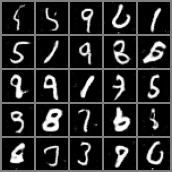


Epoch: 17/20, batch: 469/469, G_loss: 5.208039283752441, D_loss: 0.007590838707983494


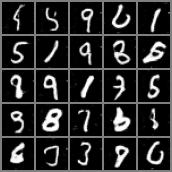


Epoch: 18/20, batch: 200/469, G_loss: 6.937485218048096, D_loss: 0.007116352207958698


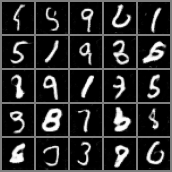


Epoch: 18/20, batch: 400/469, G_loss: 6.367717742919922, D_loss: 0.0026689572259783745


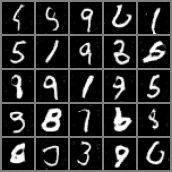


Epoch: 18/20, batch: 469/469, G_loss: 6.358133316040039, D_loss: 0.0033043520525097847


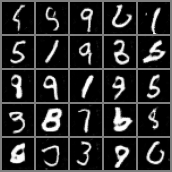


Epoch: 19/20, batch: 200/469, G_loss: 6.857385635375977, D_loss: 0.002364255953580141


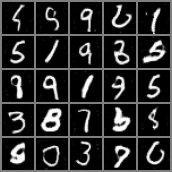


Epoch: 19/20, batch: 400/469, G_loss: 2.288778305053711, D_loss: 0.28275153040885925


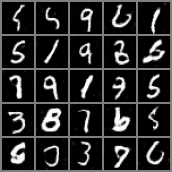


Epoch: 19/20, batch: 469/469, G_loss: 1.4008333683013916, D_loss: 0.31437066197395325


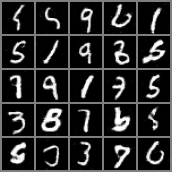


Epoch: 20/20, batch: 200/469, G_loss: 4.436731338500977, D_loss: 0.02798861265182495


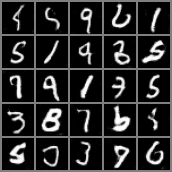


Epoch: 20/20, batch: 400/469, G_loss: 5.712739944458008, D_loss: 0.006871410645544529


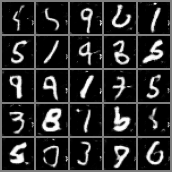


Epoch: 20/20, batch: 469/469, G_loss: 6.442604064941406, D_loss: 0.0033502578735351562


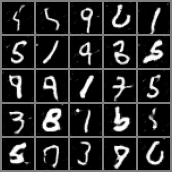

In [11]:
z_val = torch.randn(hparams['num_val_samples'], hparams['noise_size'], device=device)

for epoch in range(hparams['num_epochs']):

    for i, (real_samples, labels) in enumerate(dataloader):
        real_samples = real_samples.to(device)
        loss_g, loss_d = train_batch(real_samples, generator, discriminator, optimizer_g, optimizer_d)

        if (i+1) % 200 == 0:
            print(f"\nEpoch: {epoch+1}/{hparams['num_epochs']}, batch: {i+1}/{len(dataloader)},"
                  +f" G_loss: {loss_g}, D_loss: {loss_d}")

            fake_images = evaluate(generator, z_val)
            display(fake_images)

    print(f"\nEpoch: {epoch+1}/{hparams['num_epochs']}, batch: {i+1}/{len(dataloader)},"
          +f" G_loss: {loss_g}, D_loss: {loss_d}")

    fake_images = evaluate(generator, z_val)
    display(fake_images)


# Extra: Conditional GAN

### Exercise 4: Generator

We will now modify the generator from before to a conditional generator. To do it, we will concatenate the input to the convolutions with an embedding of the label we want to generate.

Complete the forward method. To do it, use the embedding layer with the label, and then use `torch.cat` to concatenate the label as a channel (after the corresponding `reshape`)

**Hint**: The embedding is concatenated as a new channel.

In [13]:
class ConditionalGenerator(torch.nn.Module):

    def __init__(
            self,
            noise_size: int,
            num_input_channels: int,
            num_classes: int
            ) -> None:

        super().__init__()

        # TODO: Create the Fully connected layer using nn.Linear
        self.fc = nn.Linear(noise_size, 512 * 4 * 4)

        # Embedding of the class
        self.embedding = nn.Embedding(
            num_embeddings=num_classes,
            embedding_dim=4*4,
        )

        # TODO: Create the first block
        self.convt1 = nn.Sequential(
            nn.ConvTranspose2d(512 + 1, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )


        # TODO: Create the second block
        self.convt2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        # TODO: Create the third block using nn.Sequential with ConvTranspose2d, and activation
        self.convt3 = nn.Sequential(
            nn.ConvTranspose2d(128, num_input_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )

    def forward(self, x: torch.Tensor, label: int) -> torch.Tensor:

        # TODO: Define the forward of the generator, x are random noise vectors (B, noise_size)
        # x: (B, noise_size)
        # label: (B,)

        B = x.size(0)

        # Noise to feature map
        x = self.fc(x)                  # (B, 512*4*4)
        x = x.reshape(B, 512, 4, 4)     # (B, 512, 4, 4)

        # Label embedding as spatial map
        emb = self.embedding(label)     # (B, 16)
        emb = emb.reshape(B, 1, 4, 4)   # (B, 1, 4, 4)

        # Concatenate label as an extra channel
        x = torch.cat((x, emb), dim=1)  # (B, 513, 4, 4)

        # Generator blocks
        x = self.convt1(x)
        x = self.convt2(x)
        x = self.convt3(x)

        return x

### Exercise 5: Discriminator

We will now modify the discriminator from before to a conditional discriminator. To do it, we will concatenate the input image with an embedding of the label we want to generate.

Complete the forward method. To do it, use the embedding layer with the label, and then use `torch.cat` to concatenate the label as a channel (after the corresponding `reshape`)

**Hint**: The embedding is concatenated as a new channel.

In [14]:
import torch
import torch.nn as nn

class ConditionalDiscriminator(torch.nn.Module):

    def __init__(self,
                 num_input_channels: int,
                 num_classes: int):
        super().__init__()

        self.embedding = nn.Embedding(
            num_embeddings=num_classes,
            embedding_dim=32 * 32,
        )

        # (B, C+1, 32, 32) -> (B, 128, 16, 16)
        self.conv1 = nn.Sequential(
            nn.Conv2d(num_input_channels + 1, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
        )

        # (B, 128, 16, 16) -> (B, 256, 8, 8)
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )

        # (B, 256, 8, 8) -> (B, 512, 4, 4)
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )

        # Flatten (512*4*4) -> 1
        self.fc = nn.Sequential(
            nn.Linear(512 * 4 * 4, 1),
            nn.Sigmoid(),  # Binary classification (real vs fake)
        )

    def forward(self, x: torch.Tensor, label) -> torch.Tensor:
        # x: (B, num_input_channels, 32, 32)
        # label: int or (B,) tensor

        B = x.size(0)

        # Make label a (B,) LongTensor on the same device
        if isinstance(label, int):
            label = torch.full((B,), label, dtype=torch.long, device=x.device)
        else:
            label = label.to(device=x.device, dtype=torch.long).view(-1)

        # Embed label and reshape to a 1-channel 32x32 map
        emb = self.embedding(label).reshape(B, 1, 32, 32)  # (B, 1, 32, 32)

        # Concatenate as a new channel
        x = torch.cat((x, emb), dim=1)  # (B, num_input_channels+1, 32, 32)

        # Convs
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # Flatten
        x = x.reshape(B, -1)  # (B, 512*4*4)

        # FC
        x = self.fc(x)        # (B, 1)

        return x


In [15]:
generator = ConditionalGenerator(hparams['noise_size'], hparams['num_input_channels'],
                                 hparams['num_classes']).to(device)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=hparams['learning_rate'],
                               betas=hparams['betas'])

discriminator = ConditionalDiscriminator(hparams['num_input_channels'],hparams['num_classes']).to(device)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=hparams['learning_rate'], betas=hparams['betas'])

criterion = nn.BCELoss()

def init_weights(m):
    if type(m) in {nn.Conv2d, nn.ConvTranspose2d, nn.Linear}:
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias != None:
            torch.nn.init.constant_(m.bias, 0.0)
    if type(m) == nn.BatchNorm2d:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)

generator.apply(init_weights)
discriminator.apply(init_weights);


## Train function

In [16]:
def train_batch_conditional(
        real_samples: torch.Tensor,
        real_classes: torch.Tensor,
        generator: torch.nn.Module,
        discriminator: torch.nn.Module,
        optimizer_g: torch.optim,
        optimizer_d: torch.optim,
        ) -> Tuple[float, float]:

    generator.train()
    discriminator.train()

    bsz = real_samples.shape[0]

    # TODO: Define the labels for the real (ones) and fake (zeros) images of size (bsz, 1)
    label_real = torch.ones(bsz, 1)
    label_fake = torch.zeros(bsz, 1)

    label_real = label_real.to(device)
    label_fake = label_fake.to(device)

    ####################
    # OPTIMIZE GENERATOR
    ####################

    # Reset gradients
    optimizer_g.zero_grad()

    # Generate fake samples
    z = torch.randn(bsz, hparams['noise_size'], device=device)
    fake_classes = torch.randint(0, 10, size=(bsz, 1), device=device)
    fake_samples = generator(z, fake_classes)

    # Evaluate the generated samples with the discriminator
    predictions_g_fake = discriminator(fake_samples, fake_classes)

    # Calculate error with respect to what the generator wants
    loss_g = criterion(predictions_g_fake, label_real)

    # Backpropagate
    loss_g.backward()

    # Update weights
    optimizer_g.step()

    ########################
    # OPTIMIZE DISCRIMINATOR
    ########################

    fake_samples = fake_samples.detach()

    # Reset gradients
    optimizer_d.zero_grad()

    # Calculate discriminator prediction for real samples
    predictions_d_real = discriminator(real_samples, real_classes)

    # Calculate error with respect to what the discriminator wants
    loss_d_real = criterion(predictions_d_real, label_real)

    # Calculate discriminator loss for fake samples
    predictions_d_fake = discriminator(fake_samples, fake_classes)

    # Calculate error with respect to what the discriminator wants
    loss_d_fake = criterion(predictions_d_fake, label_fake)

    # Total discriminator loss
    loss_d = (loss_d_real + loss_d_fake) / 2

    # Backpropagate
    loss_d.backward()

    # Update weights
    optimizer_d.step()

    return loss_g.item(), loss_d.item()


## Evaluation function

In [17]:
@torch.no_grad()
def evaluate_conditional(
        generator: torch.nn.Module,
        z_val: torch.Tensor,
        labels_val: torch.Tensor,
        ) -> Image.Image:

    generator.eval()
    fake_samples = generator(z_val, labels_val).cpu()
    # select a sample or create grid if img is a batch
    nrows = int(math.sqrt(fake_samples.shape[0]))
    img = utils.make_grid(fake_samples, nrow=nrows)

    # unnormalize
    img = (img*0.5 + 0.5)*255

    # to numpy
    image_numpy = img.numpy().astype(np.uint8)
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    return Image.fromarray(image_numpy)


## Train loop


Epoch: 1/20, batch: 200/469, G_loss: 3.519184112548828, D_loss: 0.11155759543180466


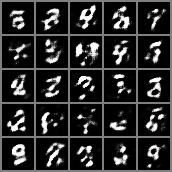


Epoch: 1/20, batch: 400/469, G_loss: 3.22426700592041, D_loss: 0.11533483862876892


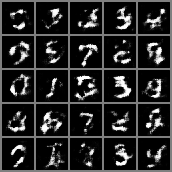


Epoch: 1/20, batch: 469/469, G_loss: 1.779401183128357, D_loss: 0.18386921286582947


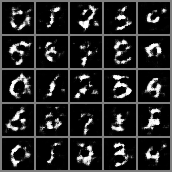


Epoch: 2/20, batch: 200/469, G_loss: 5.290933609008789, D_loss: 0.33454686403274536


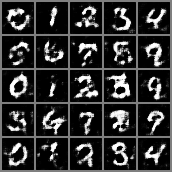


Epoch: 2/20, batch: 400/469, G_loss: 2.53182315826416, D_loss: 0.1715002954006195


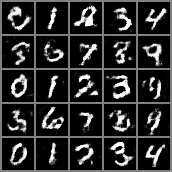


Epoch: 2/20, batch: 469/469, G_loss: 2.3864450454711914, D_loss: 0.2185933142900467


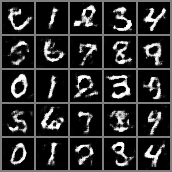


Epoch: 3/20, batch: 200/469, G_loss: 1.8059812784194946, D_loss: 0.371884286403656


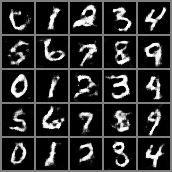


Epoch: 3/20, batch: 400/469, G_loss: 2.434943675994873, D_loss: 0.2818770408630371


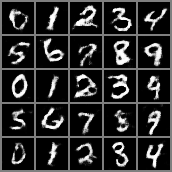


Epoch: 3/20, batch: 469/469, G_loss: 0.39710161089897156, D_loss: 0.7933820486068726


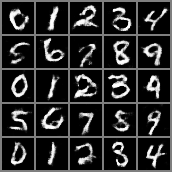


Epoch: 4/20, batch: 200/469, G_loss: 1.655308485031128, D_loss: 0.30690741539001465


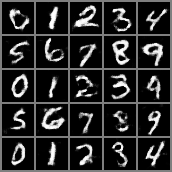


Epoch: 4/20, batch: 400/469, G_loss: 1.7347352504730225, D_loss: 0.26004981994628906


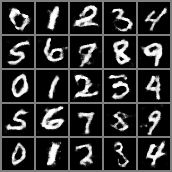


Epoch: 4/20, batch: 469/469, G_loss: 2.051074504852295, D_loss: 0.13062423467636108


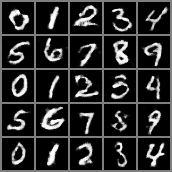


Epoch: 5/20, batch: 200/469, G_loss: 2.4329757690429688, D_loss: 0.3206378221511841


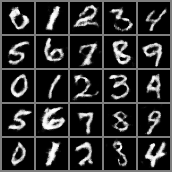


Epoch: 5/20, batch: 400/469, G_loss: 1.815220594406128, D_loss: 0.2775343060493469


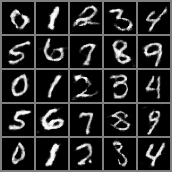


Epoch: 5/20, batch: 469/469, G_loss: 3.224560499191284, D_loss: 0.10702390968799591


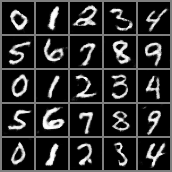


Epoch: 6/20, batch: 200/469, G_loss: 3.112356185913086, D_loss: 0.05999995395541191


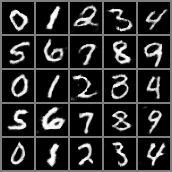


Epoch: 6/20, batch: 400/469, G_loss: 3.717738151550293, D_loss: 0.03977362811565399


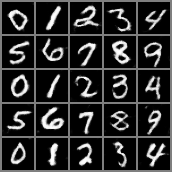


Epoch: 6/20, batch: 469/469, G_loss: 4.347179412841797, D_loss: 0.05124384164810181


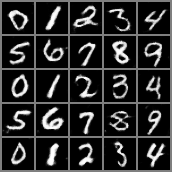


Epoch: 7/20, batch: 200/469, G_loss: 3.432673931121826, D_loss: 0.12463445961475372


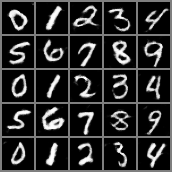


Epoch: 7/20, batch: 400/469, G_loss: 4.252484321594238, D_loss: 0.01797475479543209


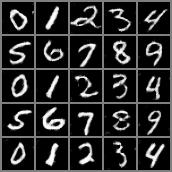


Epoch: 7/20, batch: 469/469, G_loss: 4.40865421295166, D_loss: 0.01471693441271782


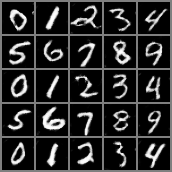


Epoch: 8/20, batch: 200/469, G_loss: 4.887269973754883, D_loss: 0.02100343257188797


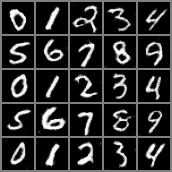


Epoch: 8/20, batch: 400/469, G_loss: 5.403573036193848, D_loss: 0.01379292830824852


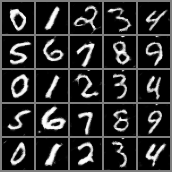


Epoch: 8/20, batch: 469/469, G_loss: 6.28958797454834, D_loss: 0.005708287004381418


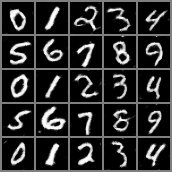


Epoch: 9/20, batch: 200/469, G_loss: 5.198159694671631, D_loss: 0.007336224429309368


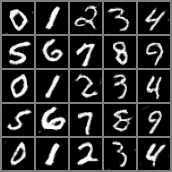


Epoch: 9/20, batch: 400/469, G_loss: 5.575766563415527, D_loss: 0.0056283543817698956


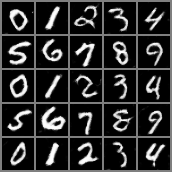


Epoch: 9/20, batch: 469/469, G_loss: 4.196205139160156, D_loss: 0.011820778250694275


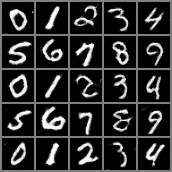


Epoch: 10/20, batch: 200/469, G_loss: 5.530481338500977, D_loss: 0.004770371131598949


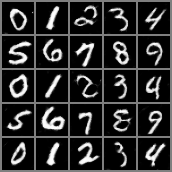


Epoch: 10/20, batch: 400/469, G_loss: 0.9963035583496094, D_loss: 0.5709225535392761


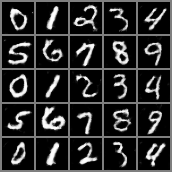


Epoch: 10/20, batch: 469/469, G_loss: 1.9524345397949219, D_loss: 0.3201605975627899


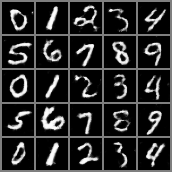


Epoch: 11/20, batch: 200/469, G_loss: 4.351483345031738, D_loss: 0.23688387870788574


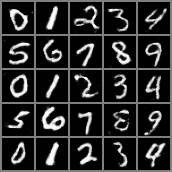


Epoch: 11/20, batch: 400/469, G_loss: 4.118147850036621, D_loss: 0.032340869307518005


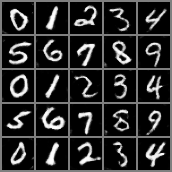


Epoch: 11/20, batch: 469/469, G_loss: 2.967721462249756, D_loss: 0.09410427510738373


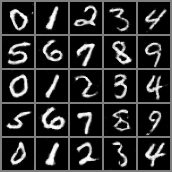


Epoch: 12/20, batch: 200/469, G_loss: 5.115377426147461, D_loss: 0.011727790348231792


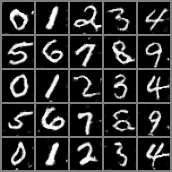


Epoch: 12/20, batch: 400/469, G_loss: 5.524270057678223, D_loss: 0.005450583063066006


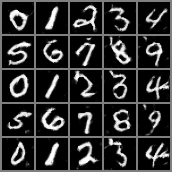


Epoch: 12/20, batch: 469/469, G_loss: 4.300367832183838, D_loss: 0.012545326724648476


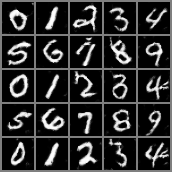


Epoch: 13/20, batch: 200/469, G_loss: 5.755631446838379, D_loss: 0.0030791491735726595


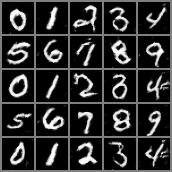


Epoch: 13/20, batch: 400/469, G_loss: 5.091936111450195, D_loss: 0.006518269889056683


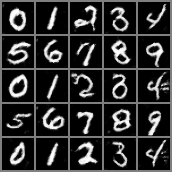


Epoch: 13/20, batch: 469/469, G_loss: 6.784627437591553, D_loss: 0.004014124628156424


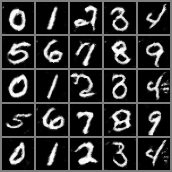


Epoch: 14/20, batch: 200/469, G_loss: 5.365666389465332, D_loss: 0.004620782099664211


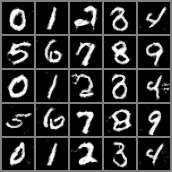


Epoch: 14/20, batch: 400/469, G_loss: 5.907575607299805, D_loss: 0.002465276513248682


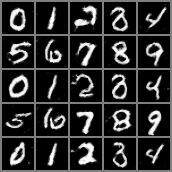


Epoch: 14/20, batch: 469/469, G_loss: 7.386348247528076, D_loss: 0.0026771954726427794


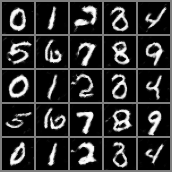


Epoch: 15/20, batch: 200/469, G_loss: 6.745321750640869, D_loss: 0.0014025191776454449


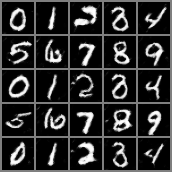


Epoch: 15/20, batch: 400/469, G_loss: 6.525659561157227, D_loss: 0.0018737423233687878


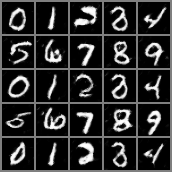


Epoch: 15/20, batch: 469/469, G_loss: 8.221189498901367, D_loss: 0.002502285409718752


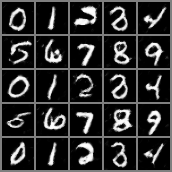


Epoch: 16/20, batch: 200/469, G_loss: 6.8531904220581055, D_loss: 0.0018848173785954714


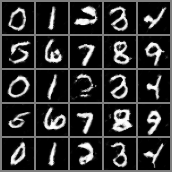


Epoch: 16/20, batch: 400/469, G_loss: 6.722765922546387, D_loss: 0.0014801830984652042


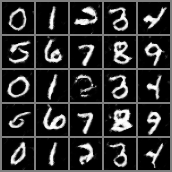


Epoch: 16/20, batch: 469/469, G_loss: 2.6612777709960938, D_loss: 0.9897267818450928


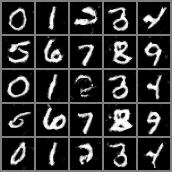


Epoch: 17/20, batch: 200/469, G_loss: 1.7943824529647827, D_loss: 0.2599108815193176


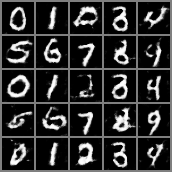


Epoch: 17/20, batch: 400/469, G_loss: 2.8721201419830322, D_loss: 0.3793167471885681


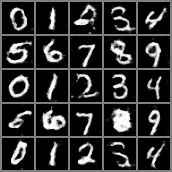


Epoch: 17/20, batch: 469/469, G_loss: 3.6375129222869873, D_loss: 0.07021893560886383


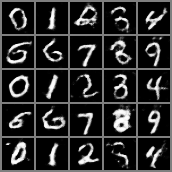


Epoch: 18/20, batch: 200/469, G_loss: 1.846930980682373, D_loss: 0.21499104797840118


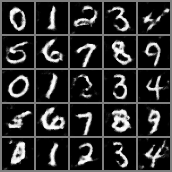


Epoch: 18/20, batch: 400/469, G_loss: 3.7375760078430176, D_loss: 0.02331719361245632


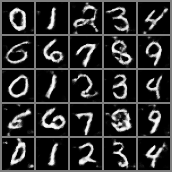


Epoch: 18/20, batch: 469/469, G_loss: 4.287553787231445, D_loss: 0.012654266320168972


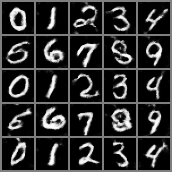


Epoch: 19/20, batch: 200/469, G_loss: 6.2153706550598145, D_loss: 0.004552681464701891


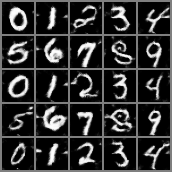


Epoch: 19/20, batch: 400/469, G_loss: 3.244551420211792, D_loss: 0.0675586611032486


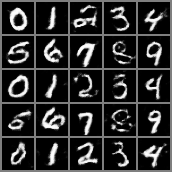


Epoch: 19/20, batch: 469/469, G_loss: 3.762369155883789, D_loss: 0.13661333918571472


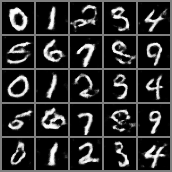


Epoch: 20/20, batch: 200/469, G_loss: 5.26962947845459, D_loss: 0.013529494404792786


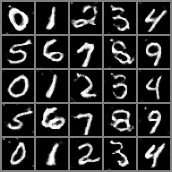


Epoch: 20/20, batch: 400/469, G_loss: 6.167823314666748, D_loss: 0.004524006508290768


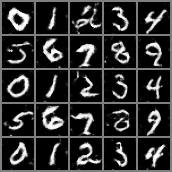


Epoch: 20/20, batch: 469/469, G_loss: 4.895234107971191, D_loss: 0.006655710283666849


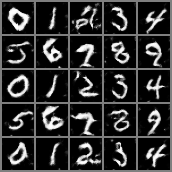

In [18]:
z_val = torch.randn(hparams['num_val_samples'], hparams['noise_size'], device=device)
labels_cycle = cycle(range(hparams['num_classes']))
labels_val = torch.tensor([next(labels_cycle) for i in range(hparams['num_val_samples'])],
                          device=device).unsqueeze(1) #the labels will be a cycle from 0 to 9

for epoch in range(hparams['num_epochs']):

    for i, (real_samples, real_classes) in enumerate(dataloader):
        real_samples = real_samples.to(device)
        real_classes = real_classes.unsqueeze(1).to(device)
        loss_g, loss_d = train_batch_conditional(
            real_samples,
            real_classes,
            generator,
            discriminator,
            optimizer_g,
            optimizer_d,
        )

        if (i+1) % 200 == 0:
            print(f"\nEpoch: {epoch+1}/{hparams['num_epochs']}, batch: {i+1}/{len(dataloader)},"
                  + f" G_loss: {loss_g}, D_loss: {loss_d}")

            fake_images = evaluate_conditional(generator, z_val, labels_val)
            display(fake_images)

    print(f"\nEpoch: {epoch+1}/{hparams['num_epochs']}, batch: {i+1}/{len(dataloader)}, "
          + f"G_loss: {loss_g}, D_loss: {loss_d}")

    fake_images = evaluate_conditional(generator, z_val, labels_val)
    display(fake_images)


### Conditional generation

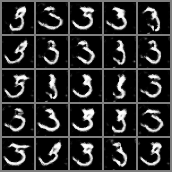

In [19]:
#You can play and visualize different numbers
number_chosen = 3
z_val = torch.randn(hparams['num_val_samples'], hparams['noise_size'], device=device)
number_chosen_torch = torch.tensor([
        number_chosen for i in range(hparams['num_val_samples'])
    ],
    device=device).unsqueeze(1)

images_number_chosen = evaluate_conditional(generator, z_val, number_chosen_torch)
display(images_number_chosen)